In [3]:
import pandas as pd 

data = pd.read_csv('C:\\Users\\lclai\\Desktop\\datamimic\\data_patients.csv')
vital_signs = pd.read_csv('C:\\Users\\lclai\\Desktop\\datamimic\\vital_signs.csv')

df = pd.merge(data, vital_signs, on='HADM_ID', how='left')

df = df.drop(columns=['SUBJECT_ID_y','DIASTOLIC_BP','SYSTOLIC_BP'])
df = df.rename(columns={'SUBJECT_ID_x': 'SUBJECT_ID'})

df.head(100)

,SUBJECT_ID,AGE,GENDER,ALZHEIMER,HADM_ID,LAST_ADMISSION_LENGTH,ETHNICITY,MARITAL_STATUS,HYPERTENSION,ATRIAL_FIBRILLATION,...,HYPERCHOLESTEROLEMIA,ESOPHAGEAL_REFLUX,KIDNEY_DISEASE,ACIDOSIS,HYPERTENSION_KIDNEY,WEIGHT,HEART_RATE,RESPIRATORY_RATE,MEAN_BP,OXYGEN_SATURATION
0,253,84,F,1,176189,5,WHITE,OTHER,1,0,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,378,71,M,1,105908,13,OTHER,MARRIED,1,0,...,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,445,83,F,1,137069,3,WHITE,OTHER,1,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,450,80,F,1,105452,18,OTHER,MARRIED,1,1,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
4,450,80,F,1,182829,11,OTHER,MARRIED,1,1,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,18377,61,F,1,140424,5,BLACK,OTHER,1,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
96,18657,79,F,1,108960,8,BLACK,OTHER,1,1,...,1,1,1,0,1,71.7,NaN,NaN,NaN,NaN
97,18657,84,F,1,121778,6,BLACK,OTHER,1,1,...,1,1,1,0,1,71.7,NaN,NaN,NaN,NaN
98,18657,85,F,1,143590,2,BLACK,OTHER,1,1,...,1,1,1,0,1,71.7,NaN,NaN,NaN,NaN


In [4]:
df = df.drop(columns=['RESPIRATORY_RATE','WEIGHT','MEAN_BP','OXYGEN_SATURATION','HEART_RATE'])
df = df.drop(columns=['SUBJECT_ID', 'HADM_ID'])
df['GENDER'] = df['GENDER'].map({'M': 1, 'F': 0})

binary = ['GENDER','ALZHEIMER','HYPERTENSION', 'ATRIAL_FIBRILLATION',
       'KIDNEY_FAILURE', 'UTI', 'HEART_FAILURE', 'RESPIRATORY_FAILURE',
       'PNEUMONITIS', 'DIABETES', 'CORONARY_ATHEROSCLEROSIS', 'HYPOTHYROIDISM',
       'ANEMIA', 'SEPSIS', 'HYPERLIPIDEMIA', 'PNEUMONIA', 'HYPEROSMOLALITY',
       'SEVERE_SEPSIS', 'HYPERCHOLESTEROLEMIA', 'ESOPHAGEAL_REFLUX',
       'KIDNEY_DISEASE', 'ACIDOSIS', 'HYPERTENSION_KIDNEY']
categorical = ['ETHNICITY','MARITAL_STATUS']
numerical = ['LAST_ADMISSION_LENGTH','AGE']

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
scaler = StandardScaler()
for col in binary + categorical:
    df[col] = le.fit_transform(df[col]) 

df[numerical] = scaler.fit_transform(df[numerical])

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ALZHEIMER']) 
y = df['ALZHEIMER']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score

models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],  
        'penalty': ['l2'], 
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200], 
        'max_depth': [None, 10, 20], 
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],  
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],  
        'learning_rate': [0.01, 0.1, 0.2], 
        'max_depth': [3, 6, 10],
        'subsample': [0.8, 1.0], 
    }
}

results = {}

for model_name in models:
    model = models[model_name]
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'mean_auc': auc,
        'best_model': best_model
    }

for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Params: {result['best_params']}")
    print(f"Mean AUC: {result['mean_auc']:.4f}\n")


Model: Logistic Regression
Best Params: {'C': 10, 'penalty': 'l2'}
Mean AUC: 0.8597

Model: Random Forest
Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean AUC: 0.9066

Model: XGBoost
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Mean AUC: 0.8874



In [10]:
#more tunning

rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Best Params for Random Forest: {grid_search_rf.best_params_}")
print(f"Mean AUC for Random Forest: {auc_rf:.4f}")


Best Params for Random Forest: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Mean AUC for Random Forest: 0.9157


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_rf_model.predict(X_test)
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14436
           1       0.06      1.00      0.11         9

    accuracy                           0.99     14445
   macro avg       0.53      0.99      0.55     14445
weighted avg       1.00      0.99      0.99     14445

[[14289   147]
 [    0     9]]


In [12]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC scores: {cv_scores}")
print(f"Mean AUC from cross-validation: {cv_scores.mean()}")

Cross-validated AUC scores: [0.87724088 0.91592024 0.8730545  0.89128613 0.87820144]
Mean AUC from cross-validation: 0.8871406382075315


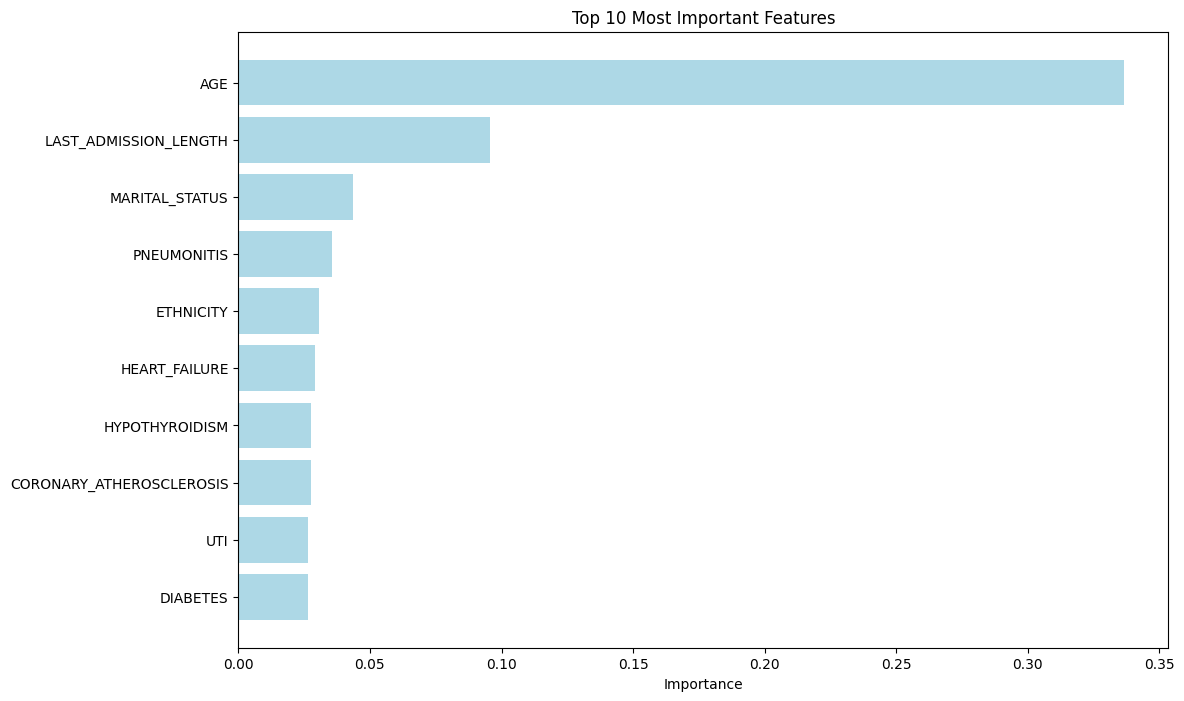

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = best_rf_model.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df.head(10)['Feature'], importance_df.head(10)['Importance'], color='lightblue')
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()